# Fresno CASES Scenarios

In [2]:
using DifferentialEquations, Plots, DelimitedFiles, CSV, DataFrames, Random, StatsPlots, KernelDensity

In [3]:
Fresno_employed = CSV.read("Fresno_employment_by_sector_2020.csv")

,Sector,Jan,Feb,Mar,Apr,Jan_Feb,Feb_Mar
,String,Int64,Int64,Int64,Int64,Float64,Float64
1,Total farm,37600,36600,34400,41000,0.000265957,0.000601093
2,Mining and logging,300,300,300,200,0.0,0.0
3,Utilities,4300,2300,2800,2500,0.00465116,-0.00217391
4,Construction,18200,18300,18300,18200,-5.49451e-5,0.0
5,Manufacturing,25900,26100,26000,24100,-7.72201e-5,3.83142e-5
6,Wholesale trade,14600,14800,14700,13500,-0.000136986,6.75676e-5
7,Retail trade,39300,38800,38400,32200,0.000127226,0.000103093
8,Transportation and warehousing,14500,14300,14400,12700,0.000137931,-6.99301e-5
9,Information,3400,3400,3400,3000,0.0,0.0


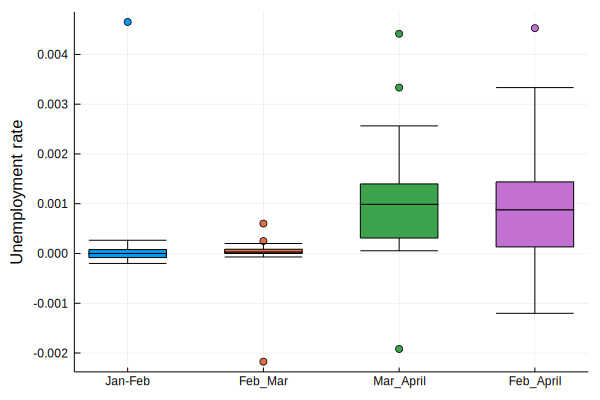

In [15]:
savefig("Fresno_rates_boxes.png")
boxplot(["Jan-Feb"], Fresno_employed[!,:Jan_Feb],leg=false,ylabel="Unemployment rate")
boxplot!(["Feb_Mar"], Fresno_employed[!,:Feb_Mar])
boxplot!(["Mar_April"], Fresno_employed[!,:Mar_April])
boxplot!(["Feb_April"], Fresno_employed[!,:Feb_April])

Load $I$ matrix

In [5]:
# reading a delimited file
reqs = readdlm("US_exchanges_2018.csv")
# transpose the USBLS array
I = reqs'
# sum the rows
sum_I = sum(I, dims=2)
# normalize elements in row according to row sums
# therefore total support for each sector sums to 1
no_sectors = size(I,1)
B = Array{Float64}(undef,no_sectors,no_sectors)
for i = 1:no_sectors
    for j = 1:no_sectors
        B[i,j] = I[i,j]/sum_I[i]
    end
end
print("I matrix\n",B)
print("\nNo. of sectors = ",no_sectors)

I matrix
[0.0 0.0362087 0.0179644 0.0117278 0.376428 0.146302 0.0081083 0.0662699 0.0190046 0.181641 0.0965441 0.000527957 0.00862731 0.00902321 0.0216225; 0.0179622 0.0 0.0220767 0.0166201 0.313975 0.0699321 0.00485752 0.0692652 0.034183 0.181282 0.224899 0.000442945 0.0115519 0.00937787 0.0235747; 0.0122537 0.147759 0.0 0.0306113 0.213831 0.0498549 0.0120094 0.118999 0.0353084 0.118697 0.181254 0.00123694 0.0166741 0.00822646 0.0532849; 0.0254843 0.0455196 0.0100785 0.0 0.427401 0.0905166 0.0603701 0.0489537 0.0253488 0.0973666 0.134706 0.00058025 0.00741011 0.0111683 0.0150958; 0.116661 0.15557 0.0233996 0.0116845 0.0 0.162723 0.00942322 0.0995589 0.0357808 0.120599 0.204489 0.000690378 0.0128792 0.0147439 0.0317968; 0.00870738 0.0130315 0.0166428 0.00922099 0.146517 0.0 0.00386072 0.087959 0.060379 0.235572 0.33 0.00243418 0.0201404 0.0297476 0.0357868; 0.0108482 0.0127908 0.0293178 0.0121981 0.130405 0.0421866 0.0 0.0831736 0.0568101 0.277948 0.265355 0.0057905 0.0188808 0.0217047

Total employment for each month

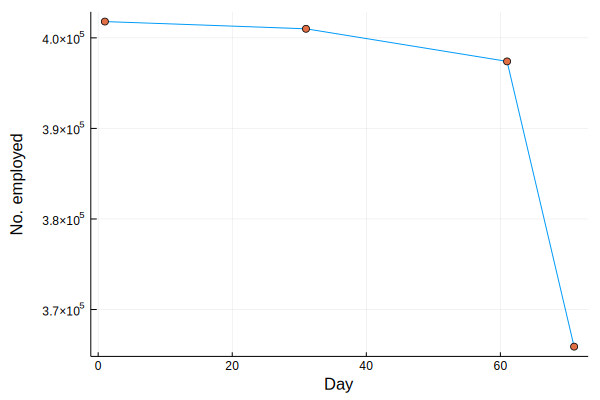

In [6]:
Total_E = [1 31 61 71; 0.00 0.00 0.00 0.00]
# calculate monthly totals
for i = 2:5
    col_sum = 0
    for j = 1:no_sectors
        col_sum = col_sum + Fresno_employed[j,i]
    end
    Total_E[2,i-1] = col_sum
end
plot(Total_E[1,:],Total_E[2,:],leg=false,xlabel="Day",ylabel="No. employed")
plot!(Total_E[1,:],Total_E[2,:],seriestype=:scatter)

## Optimistic forecast
This forecast assumes that an economic recovery begins after the end of a shutdown. We use rates from January-February, when employment rose slightly for overall, although not uniformly among sectors.

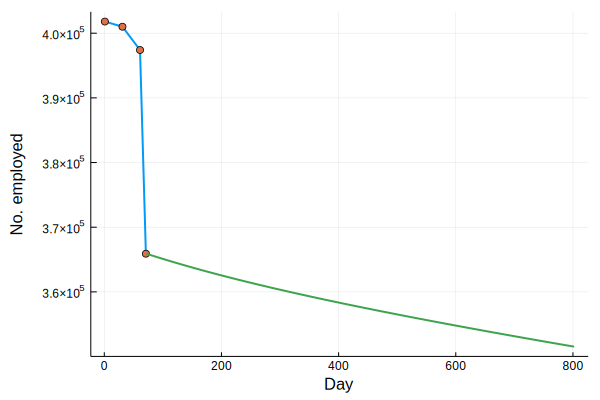

In [7]:
# write empty parameter array
p = Array{Float64}(undef,4,no_sectors)
for i = 1:no_sectors
    for j = 1:4
        p[j,i] = 0.00
    end
end

# parse rate according to layoffs or hires
for i = 1:no_sectors
    if Fresno_employed[i,:Jan_Feb] > 0.0
        p[1,i] = Fresno_employed[i,:Jan_Feb]
    else
        if Fresno_employed[i,:Jan_Feb] < 0.0
            p[3,i] = -1.0 * Fresno_employed[i,:Jan_Feb]
        end
    end
end

# initial sector sizes
u0 = Float64[]
for i = 1:no_sectors
    push!(u0,Fresno_employed[i,:Apr])
end
for i = 1:no_sectors
    push!(u0,0.00)
end

# ODE function
function sector1!(du,u,p,t)
    l,d,r = p
    du[1] = u[1]*(round((B[1,1]*u[1]/u0[1])+(B[1,2]*u[2]/u0[2])+(B[1,3]*u[3]/u0[3])+(B[1,4]*u[4]/u0[4])+(B[1,5]*u[5]/u0[5])+(B[1,6]*u[6]/u0[6])+(B[1,7]*u[7]/u0[7])+(B[1,8]*u[8]/u0[8])+(B[1,9]*u[9]/u0[9])+(B[1,10]*u[10]/u0[10])+(B[1,11]*u[11]/u0[11])+(B[1,12]*u[12]/u0[12])+(B[1,13]*u[13]/u0[13])+(B[1,14]*u[14]/u0[14])+(B[1,15]*u[15]/u0[15])) - (1.0+p[1,1]+p[2,1]+p[4,1])) + (p[3,1]*u[16])
    du[2] = u[2]*(round((B[2,1]*u[1]/u0[1])+(B[2,2]*u[2]/u0[2])+(B[2,3]*u[3]/u0[3])+(B[2,4]*u[4]/u0[4])+(B[2,5]*u[5]/u0[5])+(B[2,6]*u[6]/u0[6])+(B[2,7]*u[7]/u0[7])+(B[2,8]*u[8]/u0[8])+(B[2,9]*u[9]/u0[9])+(B[2,10]*u[10]/u0[10])+(B[2,11]*u[11]/u0[11])+(B[2,12]*u[12]/u0[12])+(B[2,13]*u[13]/u0[13])+(B[2,14]*u[14]/u0[14])+(B[2,15]*u[15]/u0[15])) - (1.0+p[1,2]+p[2,2]+p[4,2])) + (p[3,2]*u[17])
    du[3] = u[3]*(round((B[3,1]*u[1]/u0[1])+(B[3,2]*u[2]/u0[2])+(B[3,3]*u[3]/u0[3])+(B[3,4]*u[4]/u0[4])+(B[3,5]*u[5]/u0[5])+(B[3,6]*u[6]/u0[6])+(B[3,7]*u[7]/u0[7])+(B[3,8]*u[8]/u0[8])+(B[3,9]*u[9]/u0[9])+(B[3,10]*u[10]/u0[10])+(B[3,11]*u[11]/u0[11])+(B[3,12]*u[12]/u0[12])+(B[3,13]*u[13]/u0[13])+(B[3,14]*u[14]/u0[14])+(B[3,15]*u[15]/u0[15])) - (1.0+p[1,3]+p[2,3]+p[4,3])) + (p[3,3]*u[18])
    du[4] = u[4]*(round((B[4,1]*u[1]/u0[1])+(B[4,2]*u[2]/u0[2])+(B[4,3]*u[3]/u0[3])+(B[4,4]*u[4]/u0[4])+(B[4,5]*u[5]/u0[5])+(B[4,6]*u[6]/u0[6])+(B[4,7]*u[7]/u0[7])+(B[4,8]*u[8]/u0[8])+(B[4,9]*u[9]/u0[9])+(B[4,10]*u[10]/u0[10])+(B[4,11]*u[11]/u0[11])+(B[4,12]*u[12]/u0[12])+(B[4,13]*u[13]/u0[13])+(B[4,14]*u[14]/u0[14])+(B[4,15]*u[15]/u0[15])) - (1.0+p[1,4]+p[2,4]+p[4,4])) + (p[3,4]*u[19])
    du[5] = u[5]*(round((B[5,1]*u[1]/u0[1])+(B[5,2]*u[2]/u0[2])+(B[5,3]*u[3]/u0[3])+(B[5,4]*u[4]/u0[4])+(B[5,5]*u[5]/u0[5])+(B[5,6]*u[6]/u0[6])+(B[5,7]*u[7]/u0[7])+(B[5,8]*u[8]/u0[8])+(B[5,9]*u[9]/u0[9])+(B[5,10]*u[10]/u0[10])+(B[5,11]*u[11]/u0[11])+(B[5,12]*u[12]/u0[12])+(B[5,13]*u[13]/u0[13])+(B[5,14]*u[14]/u0[14])+(B[5,15]*u[15]/u0[15])) - (1.0+p[1,5]+p[2,5]+p[4,5])) + (p[3,5]*u[20])
    du[6] = u[6]*(round((B[6,1]*u[1]/u0[1])+(B[6,2]*u[2]/u0[2])+(B[6,3]*u[3]/u0[3])+(B[6,4]*u[4]/u0[4])+(B[6,5]*u[5]/u0[5])+(B[6,6]*u[6]/u0[6])+(B[6,7]*u[7]/u0[7])+(B[6,8]*u[8]/u0[8])+(B[6,9]*u[9]/u0[9])+(B[6,10]*u[10]/u0[10])+(B[6,11]*u[11]/u0[11])+(B[6,12]*u[12]/u0[12])+(B[6,13]*u[13]/u0[13])+(B[6,14]*u[14]/u0[14])+(B[6,15]*u[15]/u0[15])) - (1.0+p[1,6]+p[2,6]+p[4,6])) + (p[3,6]*u[21])
    du[7] = u[7]*(round((B[7,1]*u[1]/u0[1])+(B[7,2]*u[2]/u0[2])+(B[7,3]*u[3]/u0[3])+(B[7,4]*u[4]/u0[4])+(B[7,5]*u[5]/u0[5])+(B[7,6]*u[6]/u0[6])+(B[7,7]*u[7]/u0[7])+(B[7,8]*u[8]/u0[8])+(B[7,9]*u[9]/u0[9])+(B[7,10]*u[10]/u0[10])+(B[7,11]*u[11]/u0[11])+(B[7,12]*u[12]/u0[12])+(B[7,13]*u[13]/u0[13])+(B[7,14]*u[14]/u0[14])+(B[7,15]*u[15]/u0[15])) - (1.0+p[1,7]+p[2,7]+p[4,7])) + (p[3,7]*u[22])
    du[8] = u[8]*(round((B[8,1]*u[1]/u0[1])+(B[8,2]*u[2]/u0[2])+(B[8,3]*u[3]/u0[3])+(B[8,4]*u[4]/u0[4])+(B[8,5]*u[5]/u0[5])+(B[8,6]*u[6]/u0[6])+(B[8,7]*u[7]/u0[7])+(B[8,8]*u[8]/u0[8])+(B[8,9]*u[9]/u0[9])+(B[8,10]*u[10]/u0[10])+(B[8,11]*u[11]/u0[11])+(B[8,12]*u[12]/u0[12])+(B[8,13]*u[13]/u0[13])+(B[8,14]*u[14]/u0[14])+(B[8,15]*u[15]/u0[15])) - (1.0+p[1,8]+p[2,8]+p[4,8])) + (p[3,8]*u[23])
    du[9] = u[9]*(round((B[9,1]*u[1]/u0[1])+(B[9,2]*u[2]/u0[2])+(B[9,3]*u[3]/u0[3])+(B[9,4]*u[4]/u0[4])+(B[9,5]*u[5]/u0[5])+(B[9,6]*u[6]/u0[6])+(B[9,7]*u[7]/u0[7])+(B[9,8]*u[8]/u0[8])+(B[9,9]*u[9]/u0[9])+(B[9,10]*u[10]/u0[10])+(B[9,11]*u[11]/u0[11])+(B[9,12]*u[12]/u0[12])+(B[9,13]*u[13]/u0[13])+(B[9,14]*u[14]/u0[14])+(B[9,15]*u[15]/u0[15])) - (1.0+p[1,9]+p[2,9]+p[4,9])) + (p[3,9]*u[24])
    du[10] = u[10]*(round((B[10,1]*u[1]/u0[1])+(B[10,2]*u[2]/u0[2])+(B[10,3]*u[3]/u0[3])+(B[10,4]*u[4]/u0[4])+(B[10,5]*u[5]/u0[5])+(B[10,6]*u[6]/u0[6])+(B[10,7]*u[7]/u0[7])+(B[10,8]*u[8]/u0[8])+(B[10,9]*u[9]/u0[9])+(B[10,10]*u[10]/u0[10])+(B[10,11]*u[11]/u0[11])+(B[10,12]*u[12]/u0[12])+(B[10,13]*u[13]/u0[13])+(B[10,14]*u[14]/u0[14])+(B[10,15]*u[15]/u0[15])) - (1.0+p[1,10]+p[2,10]+p[4,10])) + (p[3,10]*u[25])
    du[11] = u[11]*(round((B[11,1]*u[1]/u0[1])+(B[11,2]*u[2]/u0[2])+(B[11,3]*u[3]/u0[3])+(B[11,4]*u[4]/u0[4])+(B[11,5]*u[5]/u0[5])+(B[11,6]*u[6]/u0[6])+(B[11,7]*u[7]/u0[7])+(B[11,8]*u[8]/u0[8])+(B[11,9]*u[9]/u0[9])+(B[11,10]*u[10]/u0[10])+(B[11,11]*u[11]/u0[11])+(B[11,12]*u[12]/u0[12])+(B[11,13]*u[13]/u0[13])+(B[11,14]*u[14]/u0[14])+(B[11,15]*u[15]/u0[15])) - (1.0+p[1,11]+p[2,11]+p[4,11])) + (p[3,11]*u[26])
    du[12] = u[12]*(round((B[12,1]*u[1]/u0[1])+(B[12,2]*u[2]/u0[2])+(B[12,3]*u[3]/u0[3])+(B[12,4]*u[4]/u0[4])+(B[12,5]*u[5]/u0[5])+(B[12,6]*u[6]/u0[6])+(B[12,7]*u[7]/u0[7])+(B[12,8]*u[8]/u0[8])+(B[12,9]*u[9]/u0[9])+(B[12,10]*u[10]/u0[10])+(B[12,11]*u[11]/u0[11])+(B[12,12]*u[12]/u0[12])+(B[12,13]*u[13]/u0[13])+(B[12,14]*u[14]/u0[14])+(B[12,15]*u[15]/u0[15])) - (1.0+p[1,12]+p[2,12]+p[4,12])) + (p[3,12]*u[27])
    du[13] = u[13]*(round((B[13,1]*u[1]/u0[1])+(B[13,2]*u[2]/u0[2])+(B[13,3]*u[3]/u0[3])+(B[13,4]*u[4]/u0[4])+(B[13,5]*u[5]/u0[5])+(B[13,6]*u[6]/u0[6])+(B[13,7]*u[7]/u0[7])+(B[13,8]*u[8]/u0[8])+(B[13,9]*u[9]/u0[9])+(B[13,10]*u[10]/u0[10])+(B[13,11]*u[11]/u0[11])+(B[13,12]*u[12]/u0[12])+(B[13,13]*u[13]/u0[13])+(B[13,14]*u[14]/u0[14])+(B[13,15]*u[15]/u0[15])) - (1.0+p[1,13]+p[2,13]+p[4,13])) + (p[3,13]*u[28])
    du[14] = u[14]*(round((B[14,1]*u[1]/u0[1])+(B[14,2]*u[2]/u0[2])+(B[14,3]*u[3]/u0[3])+(B[14,4]*u[4]/u0[4])+(B[14,5]*u[5]/u0[5])+(B[14,6]*u[6]/u0[6])+(B[14,7]*u[7]/u0[7])+(B[14,8]*u[8]/u0[8])+(B[14,9]*u[9]/u0[9])+(B[14,10]*u[10]/u0[10])+(B[14,11]*u[11]/u0[11])+(B[14,12]*u[12]/u0[12])+(B[14,13]*u[13]/u0[13])+(B[14,14]*u[14]/u0[14])+(B[14,15]*u[15]/u0[15])) - (1.0+p[1,14]+p[2,14]+p[4,14])) + (p[3,14]*u[29])
    du[15] = u[15]*(round((B[15,1]*u[1]/u0[1])+(B[15,2]*u[2]/u0[2])+(B[15,3]*u[3]/u0[3])+(B[15,4]*u[4]/u0[4])+(B[15,5]*u[5]/u0[5])+(B[15,6]*u[6]/u0[6])+(B[15,7]*u[7]/u0[7])+(B[15,8]*u[8]/u0[8])+(B[15,9]*u[9]/u0[9])+(B[15,10]*u[10]/u0[10])+(B[15,11]*u[11]/u0[11])+(B[15,12]*u[12]/u0[12])+(B[15,13]*u[13]/u0[13])+(B[15,14]*u[14]/u0[14])+(B[15,15]*u[15]/u0[15])) - (1.0+p[1,15]+p[2,15]+p[4,15])) + (p[3,15]*u[30])
     
    du[16] = (u[1]*((1.0+p[1,1]) - round((B[1,1]*u[1]/u0[1])+(B[1,2]*u[2]/u0[2])+(B[1,3]*u[3]/u0[3])+(B[1,4]*u[4]/u0[4])+(B[1,5]*u[5]/u0[5])+(B[1,6]*u[6]/u0[6])+(B[1,7]*u[7]/u0[7])+(B[1,8]*u[8]/u0[8])+(B[1,9]*u[9]/u0[9])+(B[1,10]*u[10]/u0[10])+(B[1,11]*u[11]/u0[11])+(B[1,12]*u[12]/u0[12])+(B[1,13]*u[13]/u0[13])+(B[1,14]*u[14]/u0[14])+(B[1,15]*u[15]/u0[15])))) - (u[16]*(p[2,1]+p[3,1]))
    du[17] = (u[2]*((1.0+p[1,2]) - round((B[2,1]*u[1]/u0[1])+(B[2,2]*u[2]/u0[2])+(B[2,3]*u[3]/u0[3])+(B[2,4]*u[4]/u0[4])+(B[2,5]*u[5]/u0[5])+(B[2,6]*u[6]/u0[6])+(B[2,7]*u[7]/u0[7])+(B[2,8]*u[8]/u0[8])+(B[2,9]*u[9]/u0[9])+(B[2,10]*u[10]/u0[10])+(B[2,11]*u[11]/u0[11])+(B[2,12]*u[12]/u0[12])+(B[2,13]*u[13]/u0[13])+(B[2,14]*u[14]/u0[14])+(B[2,15]*u[15]/u0[15])))) - (u[17]*(p[2,2]+p[3,2]))
    du[18] = (u[3]*((1.0+p[1,3]) - round((B[3,1]*u[1]/u0[1])+(B[3,2]*u[2]/u0[2])+(B[3,3]*u[3]/u0[3])+(B[3,4]*u[4]/u0[4])+(B[3,5]*u[5]/u0[5])+(B[3,6]*u[6]/u0[6])+(B[3,7]*u[7]/u0[7])+(B[3,8]*u[8]/u0[8])+(B[3,9]*u[9]/u0[9])+(B[3,10]*u[10]/u0[10])+(B[3,11]*u[11]/u0[11])+(B[3,12]*u[12]/u0[12])+(B[3,13]*u[13]/u0[13])+(B[3,14]*u[14]/u0[14])+(B[3,15]*u[15]/u0[15])))) - (u[18]*(p[2,3]+p[3,3]))
    du[19] = (u[4]*((1.0+p[1,4]) - round((B[4,1]*u[1]/u0[1])+(B[4,2]*u[2]/u0[2])+(B[4,3]*u[3]/u0[3])+(B[4,4]*u[4]/u0[4])+(B[4,5]*u[5]/u0[5])+(B[4,6]*u[6]/u0[6])+(B[4,7]*u[7]/u0[7])+(B[4,8]*u[8]/u0[8])+(B[4,9]*u[9]/u0[9])+(B[4,10]*u[10]/u0[10])+(B[4,11]*u[11]/u0[11])+(B[4,12]*u[12]/u0[12])+(B[4,13]*u[13]/u0[13])+(B[4,14]*u[14]/u0[14])+(B[4,15]*u[15]/u0[15])))) - (u[19]*(p[2,4]+p[3,4]))
    du[20] = (u[5]*((1.0+p[1,5]) - round((B[5,1]*u[1]/u0[1])+(B[5,2]*u[2]/u0[2])+(B[5,3]*u[3]/u0[3])+(B[5,4]*u[4]/u0[4])+(B[5,5]*u[5]/u0[5])+(B[5,6]*u[6]/u0[6])+(B[5,7]*u[7]/u0[7])+(B[5,8]*u[8]/u0[8])+(B[5,9]*u[9]/u0[9])+(B[5,10]*u[10]/u0[10])+(B[5,11]*u[11]/u0[11])+(B[5,12]*u[12]/u0[12])+(B[5,13]*u[13]/u0[13])+(B[5,14]*u[14]/u0[14])+(B[5,15]*u[15]/u0[15])))) - (u[20]*(p[2,5]+p[3,5]))
    du[21] = (u[6]*((1.0+p[1,6]) - round((B[6,1]*u[1]/u0[1])+(B[6,2]*u[2]/u0[2])+(B[6,3]*u[3]/u0[3])+(B[6,4]*u[4]/u0[4])+(B[6,5]*u[5]/u0[5])+(B[6,6]*u[6]/u0[6])+(B[6,7]*u[7]/u0[7])+(B[6,8]*u[8]/u0[8])+(B[6,9]*u[9]/u0[9])+(B[6,10]*u[10]/u0[10])+(B[6,11]*u[11]/u0[11])+(B[6,12]*u[12]/u0[12])+(B[6,13]*u[13]/u0[13])+(B[6,14]*u[14]/u0[14])+(B[6,15]*u[15]/u0[15])))) - (u[21]*(p[2,6]+p[3,6]))
    du[22] = (u[7]*((1.0+p[1,7]) - round((B[7,1]*u[1]/u0[1])+(B[7,2]*u[2]/u0[2])+(B[7,3]*u[3]/u0[3])+(B[7,4]*u[4]/u0[4])+(B[7,5]*u[5]/u0[5])+(B[7,6]*u[6]/u0[6])+(B[7,7]*u[7]/u0[7])+(B[7,8]*u[8]/u0[8])+(B[7,9]*u[9]/u0[9])+(B[7,10]*u[10]/u0[10])+(B[7,11]*u[11]/u0[11])+(B[7,12]*u[12]/u0[12])+(B[7,13]*u[13]/u0[13])+(B[7,14]*u[14]/u0[14])+(B[7,15]*u[15]/u0[15])))) - (u[22]*(p[2,7]+p[3,7]))
    du[23] = (u[8]*((1.0+p[1,8]) - round((B[8,1]*u[1]/u0[1])+(B[8,2]*u[2]/u0[2])+(B[8,3]*u[3]/u0[3])+(B[8,4]*u[4]/u0[4])+(B[8,5]*u[5]/u0[5])+(B[8,6]*u[6]/u0[6])+(B[8,7]*u[7]/u0[7])+(B[8,8]*u[8]/u0[8])+(B[8,9]*u[9]/u0[9])+(B[8,10]*u[10]/u0[10])+(B[8,11]*u[11]/u0[11])+(B[8,12]*u[12]/u0[12])+(B[8,13]*u[13]/u0[13])+(B[8,14]*u[14]/u0[14])+(B[8,15]*u[15]/u0[15])))) - (u[23]*(p[2,8]+p[3,8]))
    du[24] = (u[9]*((1.0+p[1,9]) - round((B[9,1]*u[1]/u0[1])+(B[9,2]*u[2]/u0[2])+(B[9,3]*u[3]/u0[3])+(B[9,4]*u[4]/u0[4])+(B[9,5]*u[5]/u0[5])+(B[9,6]*u[6]/u0[6])+(B[9,7]*u[7]/u0[7])+(B[9,8]*u[8]/u0[8])+(B[9,9]*u[9]/u0[9])+(B[9,10]*u[10]/u0[10])+(B[9,11]*u[11]/u0[11])+(B[9,12]*u[12]/u0[12])+(B[9,13]*u[13]/u0[13])+(B[9,14]*u[14]/u0[14])+(B[9,15]*u[15]/u0[15])))) - (u[24]*(p[2,9]+p[3,9]))
    du[25] = (u[10]*((1.0+p[1,10]) - round((B[10,1]*u[1]/u0[1])+(B[10,2]*u[2]/u0[2])+(B[10,3]*u[3]/u0[3])+(B[10,4]*u[4]/u0[4])+(B[10,5]*u[5]/u0[5])+(B[10,6]*u[6]/u0[6])+(B[10,7]*u[7]/u0[7])+(B[10,8]*u[8]/u0[8])+(B[10,9]*u[9]/u0[9])+(B[10,10]*u[10]/u0[10])+(B[10,11]*u[11]/u0[11])+(B[10,12]*u[12]/u0[12])+(B[10,13]*u[13]/u0[13])+(B[10,14]*u[14]/u0[14])+(B[10,15]*u[15]/u0[15])))) - (u[25]*(p[2,10]+p[3,10]))
    du[26] = (u[11]*((1.0+p[1,11]) - round((B[11,1]*u[1]/u0[1])+(B[11,2]*u[2]/u0[2])+(B[11,3]*u[3]/u0[3])+(B[11,4]*u[4]/u0[4])+(B[11,5]*u[5]/u0[5])+(B[11,6]*u[6]/u0[6])+(B[11,7]*u[7]/u0[7])+(B[11,8]*u[8]/u0[8])+(B[11,9]*u[9]/u0[9])+(B[11,10]*u[10]/u0[10])+(B[11,11]*u[11]/u0[11])+(B[11,12]*u[12]/u0[12])+(B[11,13]*u[13]/u0[13])+(B[11,14]*u[14]/u0[14])+(B[11,15]*u[15]/u0[15])))) - (u[26]*(p[2,11]+p[3,11]))
    du[27] = (u[12]*((1.0+p[1,12]) - round((B[12,1]*u[1]/u0[1])+(B[12,2]*u[2]/u0[2])+(B[12,3]*u[3]/u0[3])+(B[12,4]*u[4]/u0[4])+(B[12,5]*u[5]/u0[5])+(B[12,6]*u[6]/u0[6])+(B[12,7]*u[7]/u0[7])+(B[12,8]*u[8]/u0[8])+(B[12,9]*u[9]/u0[9])+(B[12,10]*u[10]/u0[10])+(B[12,11]*u[11]/u0[11])+(B[12,12]*u[12]/u0[12])+(B[12,13]*u[13]/u0[13])+(B[12,14]*u[14]/u0[14])+(B[12,15]*u[15]/u0[15])))) - (u[27]*(p[2,12]+p[3,12]))
    du[28] = (u[13]*((1.0+p[1,13]) - round((B[13,1]*u[1]/u0[1])+(B[13,2]*u[2]/u0[2])+(B[13,3]*u[3]/u0[3])+(B[13,4]*u[4]/u0[4])+(B[13,5]*u[5]/u0[5])+(B[13,6]*u[6]/u0[6])+(B[13,7]*u[7]/u0[7])+(B[13,8]*u[8]/u0[8])+(B[13,9]*u[9]/u0[9])+(B[13,10]*u[10]/u0[10])+(B[13,11]*u[11]/u0[11])+(B[13,12]*u[12]/u0[12])+(B[13,13]*u[13]/u0[13])+(B[13,14]*u[14]/u0[14])+(B[13,15]*u[15]/u0[15])))) - (u[28]*(p[2,13]+p[3,13]))
    du[29] = (u[14]*((1.0+p[1,14]) - round((B[14,1]*u[1]/u0[1])+(B[14,2]*u[2]/u0[2])+(B[14,3]*u[3]/u0[3])+(B[14,4]*u[4]/u0[4])+(B[14,5]*u[5]/u0[5])+(B[14,6]*u[6]/u0[6])+(B[14,7]*u[7]/u0[7])+(B[14,8]*u[8]/u0[8])+(B[14,9]*u[9]/u0[9])+(B[14,10]*u[10]/u0[10])+(B[14,11]*u[11]/u0[11])+(B[14,12]*u[12]/u0[12])+(B[14,13]*u[13]/u0[13])+(B[14,14]*u[14]/u0[14])+(B[14,15]*u[15]/u0[15])))) - (u[29]*(p[2,14]+p[3,14]))
    du[30] = (u[15]*((1.0+p[1,15]) - round((B[15,1]*u[1]/u0[1])+(B[15,2]*u[2]/u0[2])+(B[15,3]*u[3]/u0[3])+(B[15,4]*u[4]/u0[4])+(B[15,5]*u[5]/u0[5])+(B[15,6]*u[6]/u0[6])+(B[15,7]*u[7]/u0[7])+(B[15,8]*u[8]/u0[8])+(B[15,9]*u[9]/u0[9])+(B[15,10]*u[10]/u0[10])+(B[15,11]*u[11]/u0[11])+(B[15,12]*u[12]/u0[12])+(B[15,13]*u[13]/u0[13])+(B[15,14]*u[14]/u0[14])+(B[15,15]*u[15]/u0[15])))) - (u[30]*(p[2,15]+p[3,15]))
end

# solve ODE system
# set up the solver for the ODE (Ordinary Differential Equations)
tspan = (0.0,730.0)
prob1 = ODEProblem(sector1!,u0,tspan,p)
# to see the output values, simply remove the semi-colon at the end of the following line
sol1 = solve(prob1,saveat=1.0);
plot(sol1, leg=false, ylabel="No. employed/unemployed")

# calculate total employment
E_series = Array(sol1)
Jan_Feb_scenario = Array{Float64}(undef,731,2)
for i = 1:731
    total_e = 0.0
    for j = 1:15
        total_e = total_e + E_series[j,i]
    end
    #println(total_e)
    Jan_Feb_scenario[i,1] = i+71
    Jan_Feb_scenario[i,2] = total_e
end
#print(Jan_Feb_scenario)

# plot forecast
plot(Total_E[1,:],Total_E[2,:],leg=false,xlabel="Day",ylabel="No. employed",lw=2)
plot!(Total_E[1,:],Total_E[2,:],seriestype=:scatter)
plot!(Jan_Feb_scenario[:,1],Jan_Feb_scenario[:,2],lw=2)

## Normal scenario
Based on rates for February-March, when unemployment rose. Some of this was due to a slowing of hiring in early March, added to the initial impact of the shutdown and direct pandemic effects.

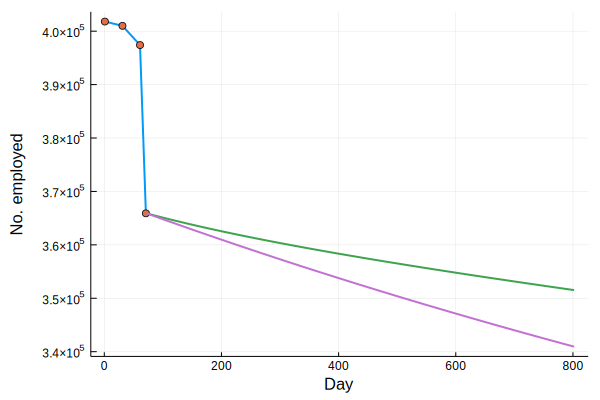

In [11]:
# write empty parameter array
p = Array{Float64}(undef,4,no_sectors)
for i = 1:no_sectors
    for j = 1:4
        p[j,i] = 0.00
    end
end

# parse rate according to layoffs or hires
for i = 1:no_sectors
    if Fresno_employed[i,:Feb_Mar] > 0.0
        p[1,i] = Fresno_employed[i,:Feb_Mar]
    else
        if Fresno_employed[i,:Feb_Mar] < 0.0
            p[3,i] = -1.0 * Fresno_employed[i,:Feb_Mar]
        end
    end
end

# initial sector sizes
u0 = Float64[]
for i = 1:no_sectors
    push!(u0,Fresno_employed[i,:Apr])
end
for i = 1:no_sectors
    push!(u0,0.00)
end

# solve ODE system
# set up the solver for the ODE (Ordinary Differential Equations)
tspan = (0.0,730.0)
prob2 = ODEProblem(sector1!,u0,tspan,p)
# to see the output values, simply remove the semi-colon at the end of the following line
sol2 = solve(prob2,saveat=1.0);
#plot(sol1, leg=false, ylabel="No. employed/unemployed")

# calculate total employment
E_series = Array(sol2)
Feb_Mar_scenario = Array{Float64}(undef,731,2)
for i = 1:731
    total_e = 0.0
    for j = 1:15
        total_e = total_e + E_series[j,i]
    end
    #println(total_e)
    Feb_Mar_scenario[i,1] = i+71
    Feb_Mar_scenario[i,2] = total_e
end
#print(Jan_Feb_scenario)

# plot forecast
plot(Total_E[1,:],Total_E[2,:],leg=false,xlabel="Day",ylabel="No. employed",lw=2)
plot!(Total_E[1,:],Total_E[2,:],seriestype=:scatter)
plot!(Jan_Feb_scenario[:,1],Jan_Feb_scenario[:,2],lw=2)
plot!(Feb_Mar_scenario[:,1],Feb_Mar_scenario[:,2],lw=2)

## Shutdown scenario
This scenario forecasts what happens if rates resulting from the shutdown continue. We first use the March-April rates.

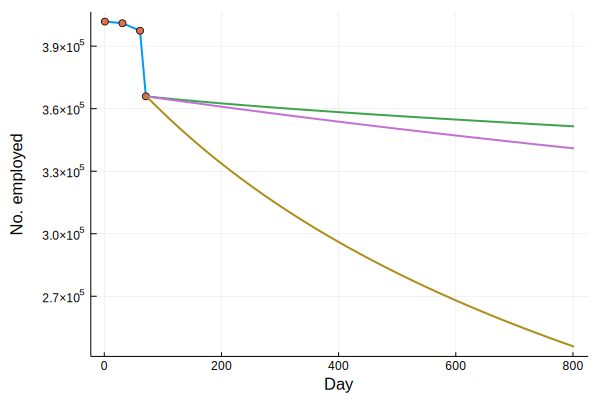

In [12]:
# write empty parameter array
p = Array{Float64}(undef,4,no_sectors)
for i = 1:no_sectors
    for j = 1:4
        p[j,i] = 0.00
    end
end

# parse rate according to layoffs or hires
for i = 1:no_sectors
    if Fresno_employed[i,:Mar_April] > 0.0
        p[1,i] = Fresno_employed[i,:Mar_April]
    else
        if Fresno_employed[i,:Mar_April] < 0.0
            p[3,i] = -1.0 * Fresno_employed[i,:Mar_April]
        end
    end
end

# initial sector sizes
u0 = Float64[]
for i = 1:no_sectors
    push!(u0,Fresno_employed[i,:Apr])
end
for i = 1:no_sectors
    push!(u0,0.00)
end

# solve ODE system
# set up the solver for the ODE (Ordinary Differential Equations)
tspan = (0.0,730.0)
prob3 = ODEProblem(sector1!,u0,tspan,p)
# to see the output values, simply remove the semi-colon at the end of the following line
sol3 = solve(prob3,saveat=1.0);
#plot(sol1, leg=false, ylabel="No. employed/unemployed")

# calculate total employment
E_series = Array(sol3)
Mar_April_scenario = Array{Float64}(undef,731,2)
for i = 1:731
    total_e = 0.0
    for j = 1:15
        total_e = total_e + E_series[j,i]
    end
    #println(total_e)
    Mar_April_scenario[i,1] = i+71
    Mar_April_scenario[i,2] = total_e
end
#print(Jan_Feb_scenario)

# plot forecast
plot(Total_E[1,:],Total_E[2,:],leg=false,xlabel="Day",ylabel="No. employed",lw=2)
plot!(Total_E[1,:],Total_E[2,:],seriestype=:scatter)
plot!(Jan_Feb_scenario[:,1],Jan_Feb_scenario[:,2],lw=2)
plot!(Feb_Mar_scenario[:,1],Feb_Mar_scenario[:,2],lw=2)
plot!(Mar_April_scenario[:,1],Mar_April_scenario[:,2],lw=2)

And finally, the next scenario uses the February-April rates, proposing that they might be a better indicator of the true impact of the shutdown, in contrast to the March-April interval which is a mixed rate.

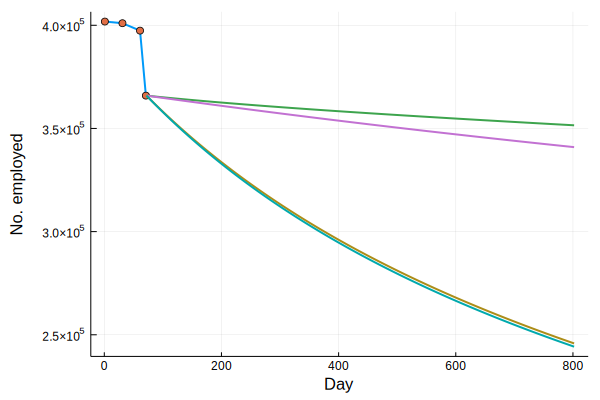

In [13]:
# write empty parameter array
p = Array{Float64}(undef,4,no_sectors)
for i = 1:no_sectors
    for j = 1:4
        p[j,i] = 0.00
    end
end

# parse rate according to layoffs or hires
for i = 1:no_sectors
    if Fresno_employed[i,:Feb_April] > 0.0
        p[1,i] = Fresno_employed[i,:Feb_April]
    else
        if Fresno_employed[i,:Feb_April] < 0.0
            p[3,i] = -1.0 * Fresno_employed[i,:Feb_April]
        end
    end
end

# initial sector sizes
u0 = Float64[]
for i = 1:no_sectors
    push!(u0,Fresno_employed[i,:Apr])
end
for i = 1:no_sectors
    push!(u0,0.00)
end

# solve ODE system
# set up the solver for the ODE (Ordinary Differential Equations)
tspan = (0.0,730.0)
prob4 = ODEProblem(sector1!,u0,tspan,p)
# to see the output values, simply remove the semi-colon at the end of the following line
sol4 = solve(prob4,saveat=1.0);
#plot(sol1, leg=false, ylabel="No. employed/unemployed")

# calculate total employment
E_series = Array(sol4)
Feb_April_scenario = Array{Float64}(undef,731,2)
for i = 1:731
    total_e = 0.0
    for j = 1:15
        total_e = total_e + E_series[j,i]
    end
    #println(total_e)
    Feb_April_scenario[i,1] = i+71
    Feb_April_scenario[i,2] = total_e
end
#print(Jan_Feb_scenario)

# plot forecast
plot(Total_E[1,:],Total_E[2,:],leg=false,xlabel="Day",ylabel="No. employed",lw=2)
plot!(Total_E[1,:],Total_E[2,:],seriestype=:scatter)
plot!(Jan_Feb_scenario[:,1],Jan_Feb_scenario[:,2],lw=2)
plot!(Feb_Mar_scenario[:,1],Feb_Mar_scenario[:,2],lw=2)
plot!(Mar_April_scenario[:,1],Mar_April_scenario[:,2],lw=2)
plot!(Feb_April_scenario[:,1],Feb_April_scenario[:,2],lw=2)

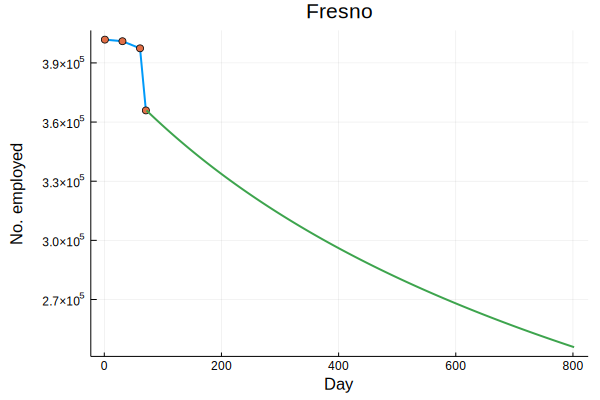

In [17]:
savefig("Fresno_Mar_April_forecast.png")
plot(Total_E[1,:],Total_E[2,:],leg=false,xlabel="Day",ylabel="No. employed",lw=2,title="Fresno")
plot!(Total_E[1,:],Total_E[2,:],seriestype=:scatter)
plot!(Mar_April_scenario[:,1],Mar_April_scenario[:,2],lw=2)

## Rate substitutions
Substitute LA rates into Fresno p-matrix.
### Manufacturing

In [18]:
print(p)

[0.0 0.00333333 0.0 5.46448e-5 0.000766284 0.000878378 0.00170103 0.00111888 0.00117647 0.000134228 0.00101493 0.000525606 0.00452722 0.00275 0.000130548; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.00120219 0.0 0.000869565 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]

In [19]:
p[1,5] = 0.00156887
print(p)

[0.0 0.00333333 0.0 5.46448e-5 0.00156887 0.000878378 0.00170103 0.00111888 0.00117647 0.000134228 0.00101493 0.000525606 0.00452722 0.00275 0.000130548; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.00120219 0.0 0.000869565 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]

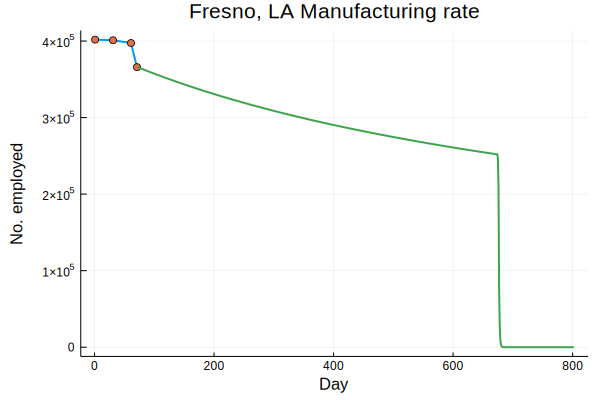

In [39]:
p1 = [0.0 0.00333333 0.0 5.46448e-5 0.000766284 0.000878378 0.00170103 0.00111888 0.00117647 0.000134228 0.00101493 0.000525606 0.00452722 0.00275 0.000130548; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.00120219 0.0 0.000869565 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
p1[1,5] = 0.00156887
# solve ODE system
# set up the solver for the ODE (Ordinary Differential Equations)
tspan = (0.0,730.0)
prob5 = ODEProblem(sector1!,u0,tspan,p1)
# to see the output values, simply remove the semi-colon at the end of the following line
sol5 = solve(prob5,saveat=1.0);
#plot(sol1, leg=false, ylabel="No. employed/unemployed")

# calculate total employment
E_series = Array(sol5)
LA_Manufacturing_scenario = Array{Float64}(undef,731,2)
for i = 1:731
    total_e = 0.0
    for j = 1:15
        total_e = total_e + E_series[j,i]
    end
    #println(total_e)
    LA_Manufacturing_scenario[i,1] = i+71
    LA_Manufacturing_scenario[i,2] = total_e
end

#savefig("Fresno_wLA_manufacturing.png")
plot(Total_E[1,:],Total_E[2,:],leg=false,xlabel="Day",ylabel="No. employed",lw=2,title="Fresno, LA Manufacturing rate")
plot!(Total_E[1,:],Total_E[2,:],seriestype=:scatter)
plot!(LA_Manufacturing_scenario[:,1],LA_Manufacturing_scenario[:,2],lw=2)

### Financial services

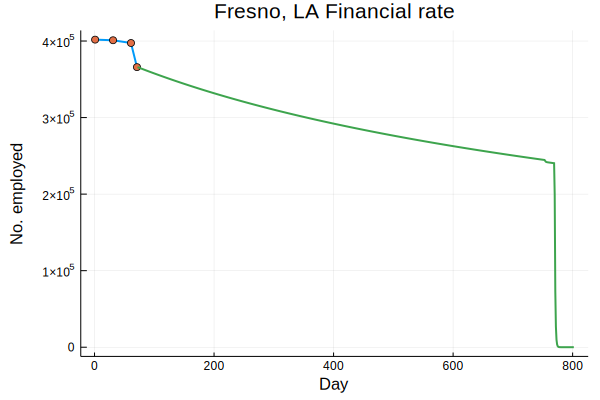

In [41]:
p2 = [0.0 0.00333333 0.0 5.46448e-5 0.000766284 0.000878378 0.00170103 0.00111888 0.00117647 0.000134228 0.00101493 0.000525606 0.00452722 0.00275 0.000130548; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.00120219 0.0 0.000869565 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
p2[1,10] = 0.000748899

tspan = (0.0,730.0)
prob6 = ODEProblem(sector1!,u0,tspan,p2)
# to see the output values, simply remove the semi-colon at the end of the following line
sol6 = solve(prob6,saveat=1.0);
#plot(sol1, leg=false, ylabel="No. employed/unemployed")

# calculate total employment
E_series = Array(sol6)
LA_Financial_scenario = Array{Float64}(undef,731,2)
for i = 1:731
    total_e = 0.0
    for j = 1:15
        total_e = total_e + E_series[j,i]
    end
    #println(total_e)
    LA_Financial_scenario[i,1] = i+71
    LA_Financial_scenario[i,2] = total_e
end

#savefig("Fresno_wLA_financial.png")
plot(Total_E[1,:],Total_E[2,:],leg=false,xlabel="Day",ylabel="No. employed",lw=2,title="Fresno, LA Financial rate")
plot!(Total_E[1,:],Total_E[2,:],seriestype=:scatter)
plot!(LA_Financial_scenario[:,1],LA_Financial_scenario[:,2],lw=2)

### Professional and business

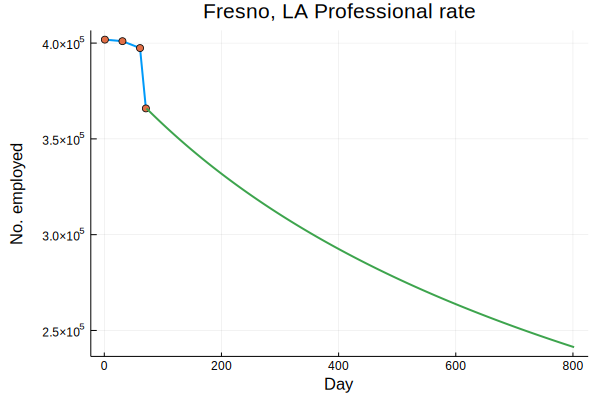

In [43]:
p3 = [0.0 0.00333333 0.0 5.46448e-5 0.000766284 0.000878378 0.00170103 0.00111888 0.00117647 0.000134228 0.00101493 0.000525606 0.00452722 0.00275 0.000130548; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.00120219 0.0 0.000869565 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
p3[1,11] = 0.00133323

tspan = (0.0,730.0)
prob6 = ODEProblem(sector1!,u0,tspan,p3)
# to see the output values, simply remove the semi-colon at the end of the following line
sol6 = solve(prob6,saveat=1.0);
#plot(sol1, leg=false, ylabel="No. employed/unemployed")

# calculate total employment
E_series = Array(sol6)
LA_Professional_scenario = Array{Float64}(undef,731,2)
for i = 1:731
    total_e = 0.0
    for j = 1:15
        total_e = total_e + E_series[j,i]
    end
    #println(total_e)
    LA_Professional_scenario[i,1] = i+71
    LA_Professional_scenario[i,2] = total_e
end

#savefig("Fresno_wLA_professional.png")
plot(Total_E[1,:],Total_E[2,:],leg=false,xlabel="Day",ylabel="No. employed",lw=2,title="Fresno, LA Professional rate")
plot!(Total_E[1,:],Total_E[2,:],seriestype=:scatter)
plot!(LA_Professional_scenario[:,1],LA_Professional_scenario[:,2],lw=2)